In [515]:
%matplotlib inline
%load_ext autoreload
%autoreload

from quanty.model import backtester as q
from quanty.model import db_manager as dm
from quanty.model import plotter as pltr
from quanty.model import setting
from quanty.model.portfolio import Port
from quanty.model.dual_momentum import DualMomentumSelector, DualMomentumPort

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [432]:
db = dm.read_db(base='prices_global.pkl', add='prices_kr.pkl')
db_kr = dm.read_db(base='prices_kr.pkl', add='prices_global.pkl')

In [502]:
base_params = {
    'start': '2002-12-31', 
    'end': '2018-03-31', 
    'db': db, 
    'assets': setting.assets_global_eq, 
    'price': {'price_src':'reprice', 'trade_tol':'at_close'}, 
    'trade': {
        'trade_assets': [
            #('BND_US_Long', {'BND_US_Interm':0.3, 'BND_US_Short':0.2}), 
            #('BND_US_Long', {'BND_US_Long':1.0}), 
        ], 
        'trade_prev_nav_based': True, 
        'trade_delay': 1, 
        'cash': 100000000, 
        'expense': 0.001, 
        'gr_exposure': 0.99, }, 
    'selecting': {
        'mode': 'DualMomentum', #'DualMomentum', 'AbsoluteMomentum', 'RelativeMomentum'
        'sig_mixer': {
            'sig_w_base': [1,0,0,0,0,0,1,0,0,0,0,0], #[1,0,0,0,0,0,1,0,0,0.25*4,0.25*6,0.25*12]
            'sig_w_dynamic': True, 
            'sig_dyn_fwd': [20,40,60], 
            'sig_dyn_m_backs': 24, 
            'sig_dyn_n_sample': 60, 
            'sig_dyn_thres': 0.1, }, 
        'market': 'ACWI', # None도 가능
        'supporter': 'BND_US_Long', 
        'cash_equiv': 'BND_US_AGG', 
        #'overwrite_to_bet': [], # base_params flattening 하므로, 반드시 list of tuple로 입력
        'follow_trend': (20,60), 
        'follow_trend_market': (20, 60), 
        'n_picks': 10, }, 
    'weighting': {
        'w_type': 'ranky2', 
        'eaa_wr': 1.0, 
        'eaa_wc': 1.0, 
        'eaa_wr_bnd': 0.5, 
        'eaa_short_period': 20, 
        'iv_period': 60, 
        'w_max': 1.0, }, 
    'stats_opts': {
        'beta_to': 'ACWI', 
        'stats_n_roll': 250, }, 
    'reinforce': {
        'follow_trend_supporter': (20, 60), 
        'support_cash': True, }, 
    'te_control': {
        'bm': None, #'ACWI', 
        'te_target': None, 
        'te_k': 0.3, 
        'te_short_period': 20, 
        'te_short_up_down_ratio_cap': True, 
        'te_short_target_cap': True, 
        'te_smoother': False, 
        'safety_buffer': 0.8, }, 
    'cash_manager': {
        'cm_method': None, #'cp', 
        'up_down_ratio_period': 20, 
        'kelly_type': 'semivariance', 
        'kelly_vol_period': 250, 
        'kelly_self_eval': True, }
}

In [441]:
#%%prun
geam = q.Backtester(base_params, w_type='inv_ranky2', start='2002-12-31')


2.6207664012908936


In [342]:
usam = q.Backtester(
    base_params, w_type='ew', start='2002-12-31', assets=setting.assets_us_sector, n_picks=5, market='US', 
    sig_w_dynamic=False, 
    #sig_dyn_fwd=[20], 
    #sig_dyn_m_backs=6, 
    #sig_w_base=[1,0,0,1,0,1],
    sig_w_base=[0,0,0,0,0,0,1,0,0,0,0,0],
)

0.35880017280578613



2.4803998470306396


In [522]:
kfam = q.Backtester(
    base_params, w_type='ew', start='2002-12-31', assets=setting.assets_kr_factor, n_picks=5, 
    price_src='underlying', db=db_kr, 
    market='K200', supporter='KTB10Y', cash_equiv='KTB3Y', 
    follow_trend=(20,20), 
    follow_trend_market=(20,20), 
    support_cash=False, 
    sig_w_dynamic=False, 
    #sig_dyn_fwd=[20], 
    #sig_dyn_m_backs=6, 
    #sig_w_base=[1,0,0,1,0,1],
    sig_w_base=[1,0,0,0,0,0,1,0,0,1,2,3],
)


2.324399948120117


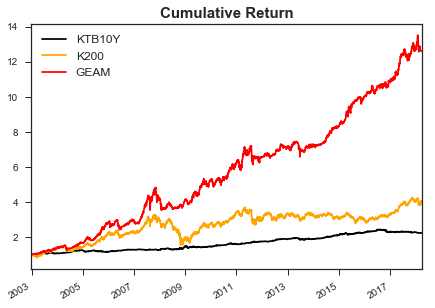

In [523]:
strats = ['KTB10Y', 'K200', 'DualMomentum']
names = ['KTB10Y', 'K200', 'GEAM']
color = ['k', 'orange', 'r']

kfam.plot_cum(strats, names=names, color=color, logy=False)

In [508]:
DualMomentumSelector(['2002-12-31'], **kfam.__dict__).sig/8*100

,Contrarian_kr,DvdGrowth_kr,Value_kr,Quality_kr,Turnaround_kr,LowVol_kr,KTB3Y,K200,HighDvd_kr,HighBeta_kr,KTB10Y,Momentum_kr,MomentumGrowth_kr,Growth_kr
2002-12-31,-8.599522,NaN,-6.416362,-4.917536,NaN,-6.219984,NaN,-9.02844,-9.685044,-6.717643,NaN,NaN,-6.228624,-8.868186


In [507]:
#kfam.port.selector.selection.iloc[0]
kfam.port.weight.iloc[0]

Contrarian_kr        0.0
DvdGrowth_kr         0.0
Value_kr             0.0
Quality_kr           0.0
Turnaround_kr        0.0
LowVol_kr            0.0
KTB3Y                0.0
K200                 0.0
HighDvd_kr           0.0
HighBeta_kr          0.0
KTB10Y               0.0
Momentum_kr          0.0
MomentumGrowth_kr    0.0
Growth_kr            0.0
Name: 2002-12-31 00:00:00, dtype: float64

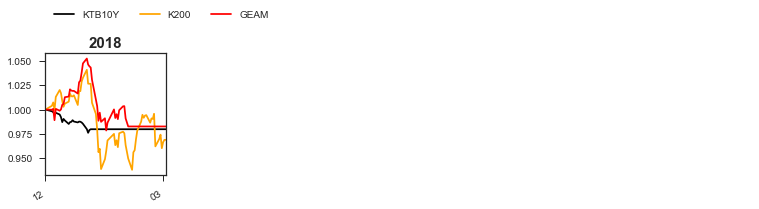

In [524]:
kfam.plot_cum_yearly(strats, names=names, color=color, remove=range(2003,2018))

In [525]:
kfam.plot_weight([2015, 2018])

KeyError: "['KTB3Y'] not in index"

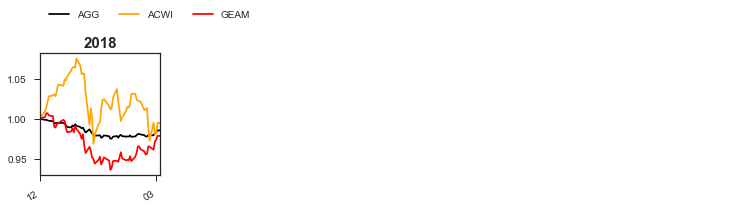

In [138]:
geam.plot_cum_yearly(strats, names=names, color=color, remove=range(2003,2018))

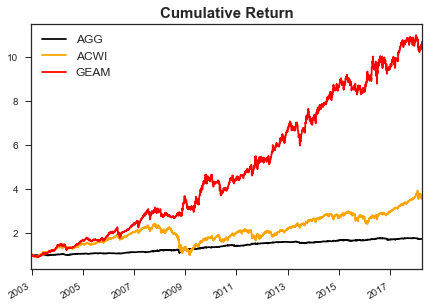

In [140]:
strats = ['BND_US_AGG', 'ACWI', 'DualMomentum']
names = ['AGG', 'ACWI', 'GEAM']
color = ['k', 'orange', 'r']

geam.plot_cum(strats, names=names, color=color, logy=False)

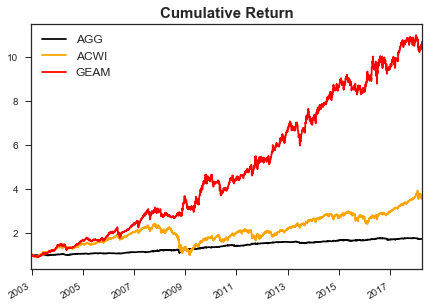

In [209]:
strats = ['BND_US_AGG', 'ACWI', 'DualMomentum']
names = ['AGG', 'ACWI', 'GEAM']
color = ['k', 'orange', 'r']

geam.plot_cum(strats, names=names, color=color, logy=False)

In [137]:
geam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
NewZealand,2.59,3839,6.39,12.28,0.52,-23.20,0.00,11.17,0.82,0.25,8.64,31.32,1.06,64.02
Russia,0.75,2751,-2.62,43.80,-0.06,-81.89,0.06,35.03,0.00,1.65,50.00,49.23,1.14,19.80
Chile,6.02,3839,12.40,23.04,0.54,-60.18,15.28,19.04,0.71,0.81,38.69,55.49,1.31,-45.83
Greece,0.70,1587,-5.37,43.46,-0.12,-77.39,10.20,40.40,0.25,1.65,43.57,51.35,1.04,28.94
DualMomentum,10.69,3839,16.69,15.32,1.09,-21.29,16.64,14.74,1.16,0.20,7.41,63.19,1.43,96.00


In [442]:
geam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
NewZealand,2.59,3839,6.39,12.28,0.52,-23.20,0.00,11.17,0.82,0.25,8.64,31.32,1.06,64.02
Russia,0.75,2751,-2.62,43.80,-0.06,-81.89,0.06,35.03,0.00,1.65,50.00,49.23,1.14,19.80
Chile,6.02,3839,12.40,23.04,0.54,-60.18,15.28,19.04,0.71,0.81,38.69,55.49,1.31,-45.83
Greece,0.70,1587,-5.37,43.46,-0.12,-77.39,10.20,40.40,0.25,1.65,43.57,51.35,1.04,28.94
DualMomentum,10.68,3839,16.68,15.32,1.09,-21.29,16.65,14.73,1.16,0.20,7.41,63.19,1.43,96.00


In [183]:
isinstance(3, float)

False

In [174]:
base_params = {
    'start': '2002-12-31', 
    'end': '2018-03-31', 
    'db': db, 
    'assets': setting.assets_fi, 
    'price': {'price_src':'reprice', 'trade_tol':'at_close'}, 
    'trade': {
        'trade_assets': [
            #('BND_US_Long', {'BND_US_Interm':0.3, 'BND_US_Short':0.2}), 
            #('BND_US_Long', {'BND_US_Long':1.0}), 
        ], 
        'trade_prev_nav_based': True, 
        'trade_delay': 1, 
        'cash': 100000000, 
        'expense': 0.001, 
        'gr_exposure': 0.99, }, 
    'selecting': {
        'mode': 'DualMomentum', 
        'sig_mixer': {
            'sig_w_base': [1,0,0,0,0,0,1,0,0,1,2,3], 
            'sig_w_dynamic': False, 
            'sig_dyn_fwd': [20,40,60], 
            'sig_dyn_m_backs': 24, 
            'sig_dyn_n_sample': 60, 
            'sig_dyn_thres': 0.1, }, 
        'market': 'BND_US_AGG', # None도 가능
        'supporter': 'BND_US_Long', 
        'cash_equiv': 'BND_US_AGG', 
        'overwrite_to_bet': [], # base_params flattening 하므로, 반드시 list of tuple로 입력
        'follow_trend': (20,60), 
        'follow_trend_market': (20, 60), 
        'n_picks': 10, }, 
    'weighting': {
        'w_type': 'ranky2', 
        'eaa_wr': 1.0, 
        'eaa_wc': 1.0, 
        'eaa_wr_bnd': 0.5, 
        'eaa_short_period': 20, 
        'iv_period': 60, 
        'w_max': 1.0, }, 
    'stats_opts': {
        'beta_to': 'ACWI', 
        'stats_n_roll': 250, }, 
    'reinforce': {
        'follow_trend_supporter': (60, 250), 
        'support_cash': True, }, 
    'te_control': {
        'bm': None, #'ACWI', 
        'te_target': None, 
        'te_k': 0.3, 
        'te_short_period': 20, 
        'te_short_up_down_ratio_cap': True, 
        'te_short_target_cap': True, 
        'te_smoother': False, 
        'safety_buffer': 0.8, }, 
    'cash_manager': {
        'cm_method': None, #'cp', 
        'up_down_ratio_period': 20, 
        'kelly_type': 'semivariance', 
        'kelly_vol_period': 250, 
        'kelly_self_eval': True, }
}

In [175]:
gfam = q.Backtester(base_params, w_type='ranky2', n_picks=5)

0.35879969596862793



2.6364002227783203


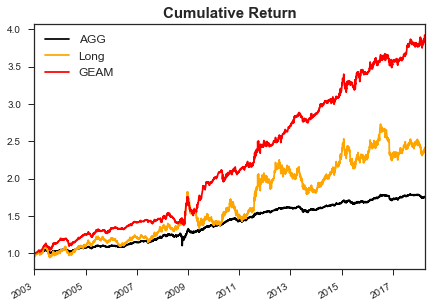

In [250]:
strats = ['BND_US_AGG', 'BND_US_Long', 'DualMomentum']
names = ['AGG', 'Long', 'GEAM']
color = ['k', 'orange', 'r']

gfam.plot_cum(strats, names=names, color=color, logy=False)

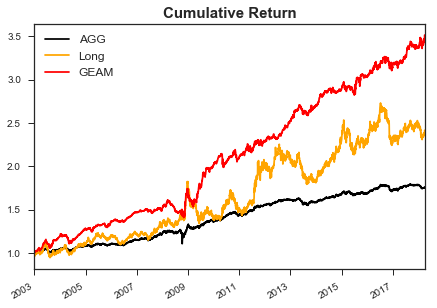

In [18]:
strats = ['BND_US_AGG', 'BND_US_Long', 'DualMomentum']
names = ['AGG', 'Long', 'GEAM']
color = ['k', 'orange', 'r']

gfam.plot_cum(strats, names=names, color=color, logy=False)

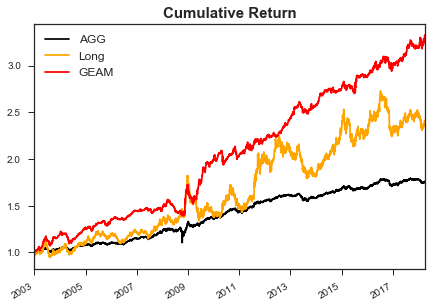

In [177]:
strats = ['BND_US_AGG', 'BND_US_Long', 'DualMomentum']
names = ['AGG', 'Long', 'GEAM']
color = ['k', 'orange', 'r']

gfam.plot_cum(strats, names=names, color=color, logy=False)

In [51]:
gfam.stats.tail()

,beta,cagr,cagr_roll_med,consistency,cum_last,hit,loss_proba,mdd,n_samples,profit_to_loss,sharpe,sharpe_roll_med,std,std_roll_med
BND_DevHY_loc,0.31,7.81,7.52,-26.47,1.94,56.73,30.38,-24.07,2204,1.25,0.70,0.65,11.16,11.36
BND_US_Long,-0.28,5.91,6.49,94.38,2.41,54.95,23.12,-26.58,3839,1.24,0.44,0.56,13.53,12.78
BND_US_CB,0.44,6.88,9.53,77.79,2.77,65.75,25.81,-47.67,3829,0.91,0.63,1.03,10.89,9.15
BND_US_Pref,0.56,4.94,5.40,69.84,2.03,67.63,17.28,-65.55,3658,0.75,0.26,0.94,18.86,6.09
DualMomentum,-0.05,9.12,7.52,98.29,3.82,69.78,3.09,-14.26,3839,1.15,1.17,1.16,7.77,6.79


In [30]:
gfam.stats.tail()

,beta,cagr,cagr_roll_med,consistency,cum_last,hit,loss_proba,mdd,n_samples,profit_to_loss,sharpe,sharpe_roll_med,std,std_roll_med
BND_EmSov_usd,0.14,8.15,8.46,87.65,3.33,70.33,15.77,-34.70,3839,0.88,0.86,1.46,9.43,6.80
BND_US_TIP,-0.05,4.14,3.98,88.73,1.86,64.29,23.20,-14.57,3839,0.99,0.67,0.83,6.22,5.48
Global,1.10,3.24,6.26,15.48,1.43,54.96,36.60,-61.52,2787,1.01,0.13,0.31,24.21,18.74
BND_US_HY,0.35,6.44,6.81,89.71,2.61,69.23,16.60,-34.25,3839,0.83,0.61,1.34,10.52,6.43
DualMomentum,0.00,8.53,7.10,97.77,3.51,67.03,3.90,-12.62,3839,1.34,1.26,1.25,6.76,5.64


In [176]:
gfam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
BND_US_IG,2.09,3839,4.91,7.75,0.63,-21.54,5.37,5.78,0.94,0.05,15.63,62.09,1.13,95.37
BND_GlobalTip_loc,1.23,2527,2.05,10.07,0.20,-29.60,3.08,8.46,0.35,0.19,32.18,59.66,0.83,31.81
BND_US_Short,1.32,3839,1.82,1.40,1.29,-2.23,1.11,1.13,1.00,-0.02,2.92,67.58,1.60,85.47
BND_US_Bankloan,2.00,3839,4.61,4.18,1.10,-33.03,4.59,2.71,2.14,0.07,17.44,74.73,0.71,88.34
DualMomentum,3.33,3839,8.15,6.60,1.23,-12.00,6.44,5.64,1.17,0.01,4.26,66.48,1.33,97.42


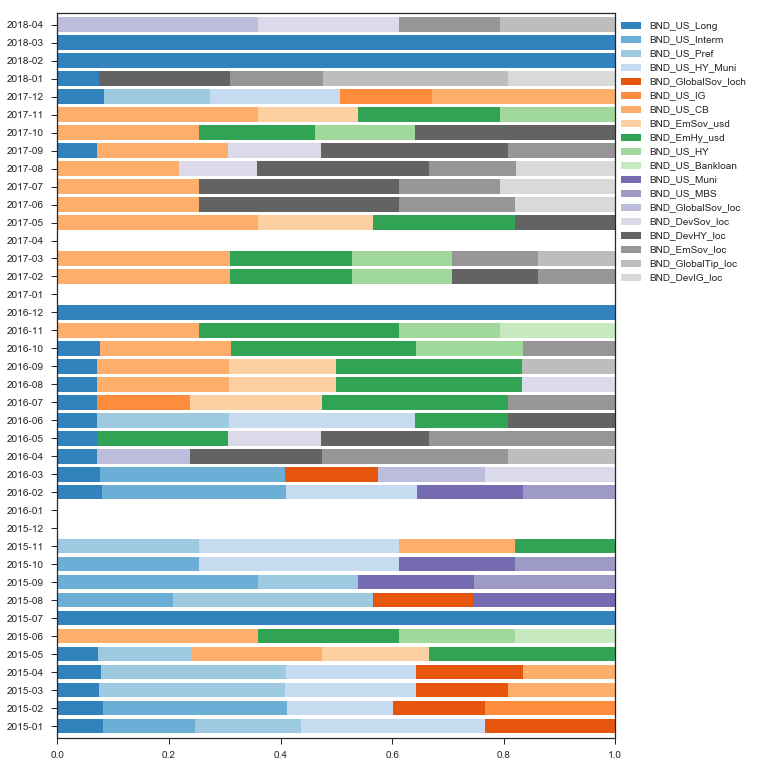

In [132]:
gfam.plot_weight([2015, 2018])

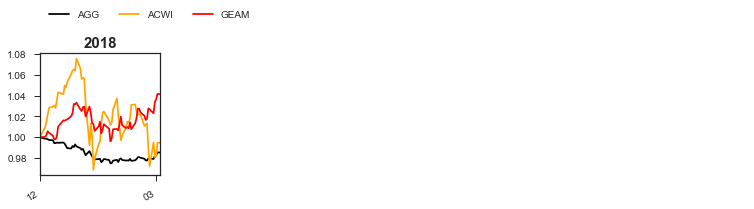

In [139]:
gfam.plot_cum_yearly(strats, names=names, color=color, remove=range(2003,2018))

In [149]:
gfam.p_close.count(axis=1)['2002-12-31':]

2002-12-31    14
2003-01-02    14
2003-01-03    14
2003-01-06    14
2003-01-07    14
2003-01-08    14
2003-01-09    14
2003-01-10    14
2003-01-13    14
2003-01-14    14
2003-01-15    15
2003-01-16    15
2003-01-17    15
2003-01-21    15
2003-01-22    15
2003-01-23    15
2003-01-24    15
2003-01-27    15
2003-01-28    15
2003-01-29    15
2003-01-30    15
2003-01-31    15
2003-02-03    15
2003-02-04    15
2003-02-05    15
2003-02-06    15
2003-02-07    15
2003-02-10    15
2003-02-11    15
2003-02-12    15
              ..
2018-02-15    24
2018-02-16    24
2018-02-20    24
2018-02-21    24
2018-02-22    24
2018-02-23    24
2018-02-26    24
2018-02-27    24
2018-02-28    24
2018-03-01    24
2018-03-02    24
2018-03-05    24
2018-03-06    24
2018-03-07    24
2018-03-08    24
2018-03-09    24
2018-03-12    24
2018-03-13    24
2018-03-14    24
2018-03-15    24
2018-03-16    24
2018-03-19    24
2018-03-20    24
2018-03-21    24
2018-03-22    24
2018-03-23    24
2018-03-26    24
2018-03-27    